# Random Masking (MADE style)

In [22]:
import os
import pdb
import numpy as np
import torch
from torchtext import data, datasets
from collections import OrderedDict as OD
import matplotlib.pyplot as plt

from transformer import * 
from utils       import * 

import seaborn as sns
sns.set(font_scale=1.5)  
sns.set_style("whitegrid")

VERBOSE = False


### Build Dataset & Model

In [23]:
train_iter, val_iter, test_iter = datasets.PennTreebank.iters(batch_size=512, device='0')
iterators = {'train': train_iter, 'valid': val_iter, 'test': test_iter}

The `device` argument should be set by using `torch.device` or passing a string as an argument. This behavior will be deprecated soon and currently defaults to cpu.
The `device` argument should be set by using `torch.device` or passing a string as an argument. This behavior will be deprecated soon and currently defaults to cpu.
The `device` argument should be set by using `torch.device` or passing a string as an argument. This behavior will be deprecated soon and currently defaults to cpu.


In [24]:
# create model and ship to GPU
gen  = make_model(10000 + 1, N=2, h=4).cuda()
# print(gen)
print('number of params', sum([np.prod([int(y) for y in x.shape]) for x in gen.parameters()]))

# build optimizer
optimizer_gen = torch.optim.Adam(gen.parameters())

number of params 16556817


### Loop over the whole dataset 

In [25]:
def full_epoch(epoch_no, split, mask_type='left to right'):
    loader = iterators[split]

    # create logging containers
    logs = OD()
    for name in ['nll', 'ppl']:
        logs[name] = []

    gen.train() if split == 'train' else gen.eval()

    # Training loop
    for i, minibatch in enumerate(loader):
       
        input  = minibatch.text.transpose(1,0).cuda()
        target = minibatch.target.transpose(1,0).cuda()
        
        bs, seq_len = input.size()
        
        if mask_type == 'left to right':
            masks = make_std_mask(target, 0)
        elif mask_type == 'random':
            masks = torch.from_numpy(build_ar_masks([seq_len] * bs)).long().cuda()
        else:
            raise ValueError('%s is an invalid mask type' % mask_type)

        logits = gen(input, masks)
        recon_loss = F.cross_entropy(logits.view(bs * seq_len, -1), target.flatten())

        if gen.training:
             optimizer_gen.zero_grad()
             recon_loss.backward()
             params = optimizer_gen.param_groups[0]['params']
             torch.nn.utils.clip_grad_norm_(params, 10, norm_type=2)
             optimizer_gen.step()
         
        logs['nll']  += [recon_loss.data]
        logs['ppl']  += [recon_loss.exp().data]

    return logs

### Plot perplexity graphs 

In [40]:
def plot(train_ppl, valid_ppl, title):
    train, valid = [], []
    for tt, vv in zip(train_ppl, valid_ppl):
        train += [torch.stack(tt).mean().item()]
        valid += [torch.stack(vv).mean().item()]
        
    plt.scatter(np.arange(len(train)), train, label='train ppl')
    plt.scatter(np.arange(len(valid)), valid, label='valid ppl')
    plt.legend()
    plt.hlines(min(valid), 0, len(valid), linestyles='dashed')
    plt.ylim(bottom=0)
    plt.xlim(-0.1, len(valid))
    plt.yticks([min(valid)] + [x for x in np.linspace(0, max(train + valid), 5)][1:])
    plt.title(title)
    plt.show()
    

### Exp1 : Baseline Model (left to right masking for training and eval)

In [27]:
train_ppl, valid_ppl, writes = [], [], 0

for epoch in range(10):
    train_log  = full_epoch(epoch, 'train', mask_type = 'left to right')
    train_ppl += [train_log['ppl']]

    if VERBOSE: 
        for key, value in train_log.items():
            print_scalar('train/%s' % key, value, writes)
        print('')
    
    with torch.no_grad():
        valid_log  = full_epoch(epoch, 'valid')
        valid_ppl += [valid_log['ppl']]

        if VERBOSE: 
            for key, value in valid_log.items():
                print_scalar('valid/%s' % key, value, writes)
            print('')
        
    writes += 1

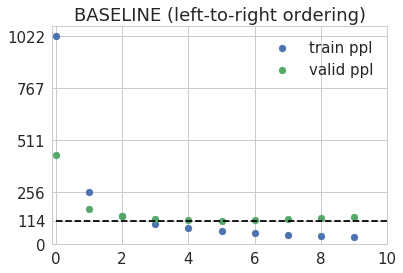

In [29]:
plot(train_ppl, valid_ppl, 'BASELINE (left-to-right ordering)')

### Exp2 : Proposed Model (random ordering masking for training and eval)

In [38]:
VERBOSE = True
gen  = make_model(10000 + 1, N=2, h=4).cuda()
optimizer_gen = torch.optim.Adam(gen.parameters())

train_ppl, valid_ppl, writes = [], [], 0

for epoch in range(10):
    train_log  = full_epoch(epoch, 'train', mask_type = 'random')
    train_ppl += [train_log['ppl']]

    if VERBOSE: 
        for key, value in train_log.items():
            print_scalar('train/%s' % key, value, writes)
        print('')
    
    with torch.no_grad():
        valid_log  = full_epoch(epoch, 'valid', mask_type='random')
        valid_ppl += [valid_log['ppl']]

        if VERBOSE: 
            for key, value in valid_log.items():
                print_scalar('valid/%s' % key, value, writes)
            print('')
        
    writes += 1

train/nll                                @ write 0 = 6.6826
train/ppl                                @ write 0 = 1050.7069

valid/nll                                @ write 0 = 6.1256
valid/ppl                                @ write 0 = 457.4389

train/nll                                @ write 1 = 5.0094
train/ppl                                @ write 1 = 188.3977

valid/nll                                @ write 1 = 3.8278
valid/ppl                                @ write 1 = 47.1530

train/nll                                @ write 2 = 3.3425
train/ppl                                @ write 2 = 29.1116

valid/nll                                @ write 2 = 3.1309
valid/ppl                                @ write 2 = 23.7586

train/nll                                @ write 3 = 2.8358
train/ppl                                @ write 3 = 17.0934

valid/nll                                @ write 3 = 2.9280
valid/ppl                                @ write 3 = 19.4245

train/nll           

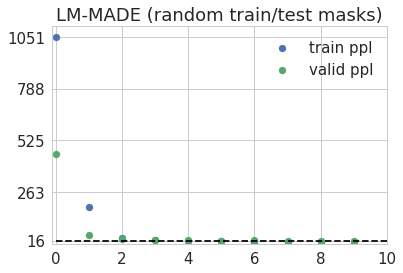

In [41]:
plot(train_ppl, valid_ppl, 'LM-MADE (random train/test masks)')

### Comments on results 

Perplexity wise, these results are very promising. Let's see if this gain simply comes from evaluating with random orderings, or that training with random masks actually helps. To do so, we train using the regular ordering, and evaluate with random masks

In [43]:
VERBOSE = False
gen  = make_model(10000 + 1, N=2, h=4).cuda()
optimizer_gen = torch.optim.Adam(gen.parameters())

train_ppl, valid_ppl, writes = [], [], 0

for epoch in range(10):
    train_log  = full_epoch(epoch, 'train', mask_type = 'left to right')
    train_ppl += [train_log['ppl']]

    if VERBOSE: 
        for key, value in train_log.items():
            print_scalar('train/%s' % key, value, writes)
        print('')
    
    with torch.no_grad():
        valid_log  = full_epoch(epoch, 'valid', mask_type='random')
        valid_ppl += [valid_log['ppl']]

        if VERBOSE: 
            for key, value in valid_log.items():
                print_scalar('valid/%s' % key, value, writes)
            print('')
        
    writes += 1

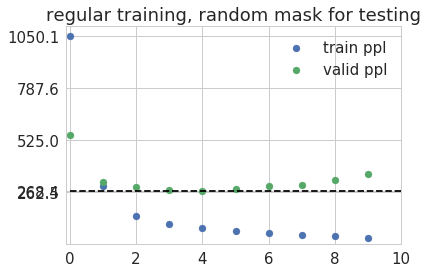

In [45]:
plot(train_ppl, valid_ppl, 'regular training, random mask for testing')

Last thing to try : Train on random orderings but evaluate only on left-to-right orderings

In [46]:
VERBOSE = False
gen  = make_model(10000 + 1, N=2, h=4).cuda()
optimizer_gen = torch.optim.Adam(gen.parameters())

train_ppl, valid_ppl, writes = [], [], 0

for epoch in range(10):
    train_log  = full_epoch(epoch, 'train', mask_type = 'random')
    train_ppl += [train_log['ppl']]

    if VERBOSE: 
        for key, value in train_log.items():
            print_scalar('train/%s' % key, value, writes)
        print('')
    
    with torch.no_grad():
        valid_log  = full_epoch(epoch, 'valid', mask_type='left to right')
        valid_ppl += [valid_log['ppl']]

        if VERBOSE: 
            for key, value in valid_log.items():
                print_scalar('valid/%s' % key, value, writes)
            print('')
        
    writes += 1

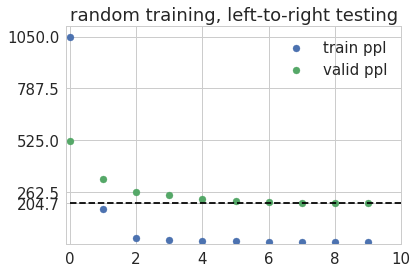

In [47]:
plot(train_ppl, valid_ppl, 'random training, left-to-right testing')